#Convert a Custom Model for MNIST Dataset to ONNX and Inference with ONNX Runtime

This example performs a conversion of a 'hand-crafted' CNN for the MNIST dataset, loosely based on the lenet CNN. It creates a model in keras, evaluates it, converts it to ONNX format. Finnaly, it loads the created ONNX file to perform predictions and compare it againt keras' predictions. 

In [12]:
import sys
import os
import tensorflow as tf
print("TensorFlow version is "+tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

TensorFlow version is 2.2.0


# Preparing the MNIST Dataset

In [13]:
# Get MNIST dataset
mnist = tf.keras.datasets.mnist
# Load its data into training and test vectors
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
# Collect feature size info
imgSize0=len(x_train[0])
imgSize1=len(x_train[0][0])
numPixels=imgSize0*imgSize1
numTrainImages=len(x_train)
featureShape=(1,imgSize0,imgSize1)

print("Training dataset has "+str(numTrainImages))
print("Testing dataset has "+str(len(x_test)))
print("Feature shape is "+str(featureShape))

Training dataset has 60000
Testing dataset has 10000
Feature shape is (1, 28, 28)


In [14]:
train_labels_count = np.unique(y_train, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [15]:
test_labels_count = np.unique(y_test, return_counts=True)
dataframe_test_labels = pd.DataFrame({'Label':test_labels_count[0], 'Count':test_labels_count[1]})
dataframe_test_labels

,Label,Count
0,0,980
1,1,1135
2,2,1032
3,3,1010
4,4,982
5,5,892
6,6,958
7,7,1028
8,8,974
9,9,1009


# Building or Loading the CNN Model with Keras

If you are building a model in keras to convert it to ONNX, it's realy important that the first layer defines the ***input_shape***, otherwise you will see errors in the ONNX conversion. See [Issue #493](https://github.com/onnx/keras-onnx/issues/493) for more information.


In [16]:
# Clearup everything before running
tf.keras.backend.clear_session()

print ('creating a new model')
# Clearup everything before running
tf.keras.backend.clear_session()
# Create model
model = tf.keras.models.Sequential()
# Add layers
# The first layer MUST have input_shape. See the observation above.
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Build model and print summary
model.build(input_shape=featureShape)
model.summary()

creating a new model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Training Model
Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5394 - accuracy: 0.8426
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3159 - accuracy: 0.9092
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2891 - accuracy: 0.9165
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2713 - accuracy: 0.9224
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2592 - accuracy: 0.9263
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2510 - accuracy: 0.9285
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2441 - accuracy: 0.9310
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2391 - accuracy: 0.9325
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2343 - accuracy: 0.9337
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/ste

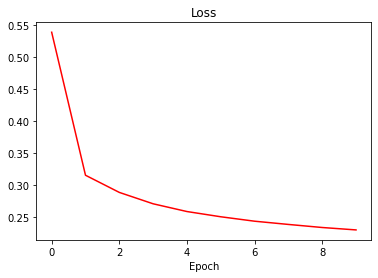

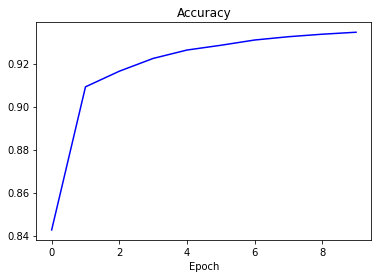

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
print("Training Model")
# increase the number of epochs if you wish better accuracy
history = model.fit(x_train, y_train, epochs=10)
plt.plot(history.history["loss"], color='r')
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()
plt.plot(history.history["accuracy"], color='b')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Evaluate the Keras' Model Performance




In [18]:
keras_test_loss, keras_test_acc = model.evaluate(x_test, y_test)

print('Test loss:', keras_test_loss)
print('Test accuracy:', keras_test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.2376 - accuracy: 0.9352
Test loss: 0.23761823773384094
Test accuracy: 0.9351999759674072


In [0]:
# if the model is just created, them I want to update saved model
model.save('./mnist-model.h5') 

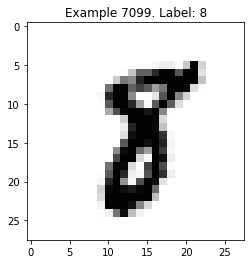

In [20]:
# get a random image index from the test set
image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
expected_label = y_test[image_index]
digit_image = x_test[image_index]
# and plot it
plt.title('Example %d. Label: %d' % (image_index, expected_label))
plt.imshow(digit_image, cmap='Greys')
plt.show()

In [0]:
# uncomment the following two lines to save sample images with digits
#pil_img = tf.keras.preprocessing.image.array_to_img(digit_image.reshape((imgSize0,imgSize1,1)))
#pil_img.save('./str(expected_label)+'.bmp')

In [22]:
# reshape the image for inference/prediction
digit_image = digit_image.reshape(1, imgSize0, imgSize1, 1)
# repeat few times to take the average execution time
loop_count = 10

start_time = time.time()
for i in range(loop_count):
    prediction = model.predict(digit_image)
print("Keras inferences with %s second in average" %((time.time() - start_time) / loop_count))

print(prediction)
predicted_label = prediction.argmax()
print('Predicted value:', predicted_label)
if (expected_label == predicted_label):
  print('Correct prediction !')
else:
  print('Wrong prediction !')

# one suggestion is to place this and the previous cell inside a for loop to perform several inferences

Keras inferences with 0.032799935340881346 second in average
[[5.1793786e-06 1.3430116e-03 1.7588119e-03 2.7343312e-03 7.1471358e-09
  5.0697732e-03 1.4563107e-06 2.6127812e-04 9.8847544e-01 3.5068262e-04]]
Predicted value: 8
Correct prediction !


# Conversion from Keras to ONNX

Now we know that the keras model is working, let's **convert it to ONNX** format and reevaluate the model again.

In [23]:
# let's install the onnx packages from the source
!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

Now we use Keras2onnx to convert the model to ONNX format and save it.

In [24]:
import keras2onnx
print("keras2onnx version is "+keras2onnx.__version__)
# convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'mnist-onnx', debug_mode=1)
output_model_path = "./mnist-model.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_1/Identity:0
	input : dense/Identity:0
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Identity:0
	input : flatten/Identity:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Identity:0
	input : flatten_input:0
var: flatten_input
var: flatten_input:0
var: flatten_input:01
var: flatten/Identity:0
var: dense/Identity:0
var: dense_1/Identity:01
var: dense_1/Identity:0
var: dense_1
Converting the operator (Identity): Identity
Converting the operator (Identity1): Identity
Converting the operator (Identity2): Identity
Converting the operator (dense_1): <class 'tensorflow.python.keras.layers.core.Dense'>
Converting the operator (dense): <class 'tensorflow.python.keras.layers.core.Dense'>
Converting the operator (fl

keras2onnx version is 1.7.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________
None


# Evaluate the ONNX's Model Performance

Now let's reevaluate the model read from the ONNX format to see if it is working.

In [0]:
import onnxruntime

sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)
data = [digit_image.astype(np.float32)]
input_names = sess.get_inputs()
feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])

In [26]:
start_time = time.time()
for i in range(loop_count):
    onnx_predicted_label = sess.run(None, feed)[0].argmax()
print("ONNX inferences with %s second in average" %((time.time() - start_time) / loop_count))

print('ONNX predicted value:', onnx_predicted_label)
if (expected_label == onnx_predicted_label):
  print('Correct prediction !')
else:
  print('Wrong prediction !')

if (predicted_label == onnx_predicted_label):
  print("The ONNX's and keras' prediction are matching !")
else:
  print("The ONNX's and keras' prediction does not match !")


ONNX inferences with 0.0009166479110717773 second in average
ONNX predicted value: 8
Correct prediction !
The ONNX's and keras' prediction are matching !
